In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

%matplotlib inline

In [23]:
User = 'HJ'
if User == 'YH':
    train = pd.read_csv(r'..\SunPower_Prediction_20201220\data\train\train.csv')
    test = pd.read_csv(r'..\SunPower_Prediction_20201220\data\test\1.csv') # From 1 to 80
else:
    train = pd.read_csv(r'..\Sun Light\train\train.csv')
    test = pd.read_csv(r'..\Sun Light\test\1.csv') # From 1 to 80

In [5]:
submission = pd.read_csv(r'.\sample_submission.csv')

Hour - 시간<br>
Minute - 분 <br>
DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2)) <br>
DNI - 직달일사량(Direct Normal Irradiance (W/m2)) <br>
WS - 풍속(Wind Speed (m/s)) <br>
RH - 상대습도(Relative Humidity (%)) <br>
T - 기온(Temperature (Degree C)) <br>
Target - 태양광 발전량 (kW) 

In [24]:
train_wo_date = train.drop(columns=['Day','Hour','Minute']) # delete Date (anyway it is timely indexed.)

In [25]:
train_wo_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 6 columns):
DHI       52560 non-null int64
DNI       52560 non-null int64
WS        52560 non-null float64
RH        52560 non-null float64
T         52560 non-null int64
TARGET    52560 non-null float64
dtypes: float64(3), int64(3)
memory usage: 2.4 MB


In [26]:
train_wo_date.isnull().sum()

DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

No Null Value & All value is number (no object & string) ! Nice !

In [27]:
df = pd.DataFrame(train_wo_date, columns=train_wo_date.columns)


In [28]:
# data = df.rolling(50).mean()
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(16, 6))
# sns.lineplot(data=data, palette="tab10", linewidth=5)

In [29]:
# df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()

In [34]:
df

,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.125000,0.665404,0.129630,0.0
1,0.0,0.0,0.125000,0.665188,0.129630,0.0
2,0.0,0.0,0.133333,0.694622,0.129630,0.0
3,0.0,0.0,0.133333,0.694297,0.129630,0.0
4,0.0,0.0,0.133333,0.731631,0.129630,0.0
...,...,...,...,...,...,...
52555,0.0,0.0,0.200000,0.682935,0.277778,0.0
52556,0.0,0.0,0.200000,0.640623,0.277778,0.0
52557,0.0,0.0,0.183333,0.640515,0.277778,0.0
52558,0.0,0.0,0.175000,0.650687,0.277778,0.0


In [31]:
def normalize(df):
    result = df.copy()
    for feature_name in [x for i,x in enumerate(df) if x!='TARGET'] : # exclude Date column for normalization.
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

df = normalize(df)

# drop_columns = ['TARGET']
# for col in df.columns: # avoid deviding by zero during normalization
#     if df[col].max()==df[col].min():
#         drop_columns.append(col)
# df=(df-df.min())/(df.max()-df.min())  # Normalization

num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

## 1. Indexex and offsets

In [35]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['TARGET']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [36]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [37]:
def plot(self, model=None, plot_col='TARGET', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [38]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=2*24, # daily sliding  
      shuffle=False,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [39]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Input Size = 7days of data = 7 x 24 x 2 <br>
Output Size = 2days of prediction = 2 x 24 x 2 

No example batch was found, so get one from the `.train` dataset


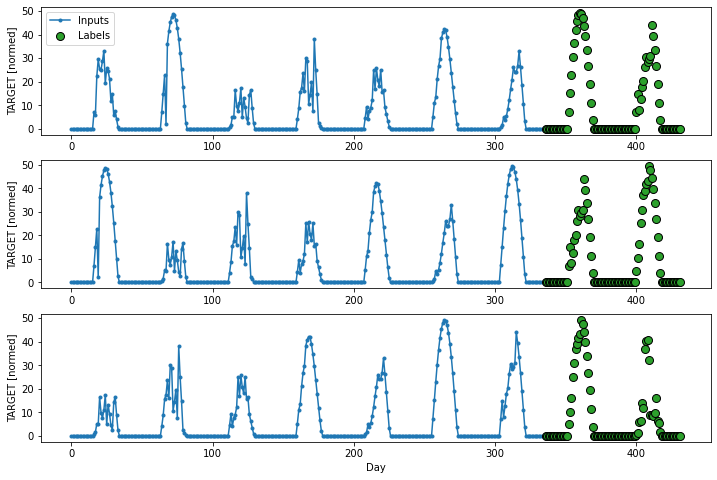

In [40]:
IN_STEPS = 7*24*2
OUT_STEPS = 2*24*2
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['TARGET'],
                              train_df=train_df, val_df=val_df, test_df=test_df,)

multi_window.plot()

In [108]:
next(iter(multi_window.train))[1].shape

TensorShape([64, 96, 1])

In [111]:
multi_gru_model(next(iter(multi_window.train))[0]).shape

TensorShape([64, 96, 1])

loss function 자체는 문제가 없음을 아래를 통해서 확인 가능함.

In [169]:
qs = np.linspace(0.1, 0.9, num=9)
q = tf.constant(np.array(qs), dtype=tf.float32)
e = next(iter(multi_window.train))[1] - multi_gru_model(next(iter(multi_window.train))[0])
v = tf.maximum(q*e, (q-1)*e)
K.mean(v, axis=-1)

<tf.Tensor: shape=(64, 96), dtype=float32, numpy=
array([[0.00278214, 0.0093652 , 0.01504208, ..., 0.0173883 , 0.01881318,
        0.03317512],
       [0.00709979, 0.02014565, 0.00449037, ..., 0.02033839, 0.02026919,
        0.05049219],
       [0.00668306, 0.0170924 , 0.00650393, ..., 0.02004491, 0.02138226,
        0.04323694],
       ...,
       [0.00362289, 0.00759047, 0.00300879, ..., 0.01570279, 0.01556668,
        0.04120784],
       [0.00278155, 0.00703725, 0.00581603, ..., 0.01613524, 0.01596358,
        0.03893789],
       [0.00492672, 0.00519091, 0.00983584, ..., 0.01622979, 0.01658335,
        0.04015687]], dtype=float32)>

In [197]:
def qloss(model,window):
    # Pinball loss for multiple quantiles
    qs = np.linspace(0.1, 0.9, num=9)
    q = tf.constant(np.array(qs), dtype=tf.float32)
    inp , labels = next(iter(window.train))  
#     e = labels - model(inp) 
    e = abs(labels - model(inp))
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v, axis=-1)

In [198]:
def compile_and_fit(model, window, patience=5, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

#     model.compile(loss=tf.losses.MeanSquaredError(),
    model.compile(loss=qloss(model,window),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()]
                 )
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                       )
    return history

val_performance = {}
performance = {}

In [199]:
def plot_history(history_object, plot_columns = ['TARGET']):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

In [200]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.Dense(15),
    tf.keras.layers.GRU(30, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(30), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

In [201]:
history1 = compile_and_fit(multi_gru_model, multi_window, epochs=1)
# plot_history(history)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
In_0.shape

(336, 6)

In [71]:
test['TARGET'].max()

49.54939214

In [64]:
shape = (1,)+In_0.shape 
In_0=pd.DataFrame.to_numpy(test[['DHI','DNI','WS','RH','T','TARGET']]).reshape(shape)

In [65]:
prediction=np.array([])
out_list = [In_0]
for i in out_list:
    prediction=np.append(prediction,multi_gru_model.predict((i), verbose=1).tolist(),axis=None)


prediction

1/1 [==============================] - 0s 4ms/step


array([ 3.84740345e-03,  2.43865222e-01,  2.10184008e-01, -4.64438088e-02,
       -5.07823348e-01,  4.17420477e-01,  1.02968790e-01, -3.19621205e-01,
        2.94577271e-01,  3.91681015e-01, -2.68267095e-01, -4.32772756e-01,
        1.09599777e-01,  1.69107258e-01,  2.40355596e-01,  4.34957109e-02,
        4.22116458e-01,  7.91282654e-01,  8.31722319e-01,  6.54999852e-01,
        4.81343418e-01,  2.75568157e-01,  9.07958388e-01,  9.00757551e-01,
        9.75000560e-02,  9.05536711e-01,  8.44903529e-01,  7.76484787e-01,
        3.64685506e-01,  2.62870461e-01,  3.05811048e-01, -7.46998936e-04,
       -3.68119068e-02,  7.33853579e-02,  4.60231900e-01,  1.43293180e-02,
       -1.15087062e-01, -1.95720568e-01,  2.75332570e-01, -1.36427194e-01,
       -4.34009552e-01,  2.59648681e-01, -6.07255846e-04, -3.32070440e-01,
       -6.56179190e-02,  6.21965826e-01,  2.51656026e-01, -3.32212776e-01,
       -2.53120244e-01,  6.57761190e-03, -1.44536234e-03,  2.65340880e-03,
        1.63736671e-01,  

In [ ]:
val_performance['M_GRU'] = multi_gru_model.evaluate(multi_window.val)
performance['M_GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

In [ ]:
CONV_WIDTH = IN_STEPS
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=100)
plot_history(history)

In [ ]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [30]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [31]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

prediction.shape (64, 6)
Output shape (batch, time, features):  (64, 96, 6)


In [37]:
print(prediction)

tf.Tensor(
[[-0.11676886 -0.03282719 -0.07611771 -0.09217425  0.01472939 -0.04549323]
 [-0.23140424 -0.05981897 -0.07152002 -0.11859042  0.02595535 -0.11136261]
 [-0.17299347 -0.0509218  -0.0726136  -0.10894932  0.02081809 -0.07804482]
 [-0.18746132 -0.0368264  -0.08333123 -0.1221872   0.02501842 -0.0761043 ]
 [-0.2579895  -0.04157705 -0.09928144 -0.14261466  0.04346325 -0.1339429 ]
 [-0.22167978 -0.03640868 -0.08813663 -0.123731    0.03588178 -0.11442071]
 [-0.24826431 -0.05132131 -0.08110625 -0.12954707  0.03602216 -0.13551606]
 [-0.131675   -0.02954556 -0.06142316 -0.08574567  0.01237688 -0.04745277]
 [-0.08413361 -0.03644687 -0.05806138 -0.08444598  0.00363571 -0.00983804]
 [-0.0988621  -0.03811609 -0.06468473 -0.09535306  0.01063626 -0.03111614]
 [-0.05958123 -0.03620031 -0.04798315 -0.07190181  0.00100504 -0.01017074]
 [-0.15444973 -0.0407977  -0.07710959 -0.11352284  0.01968211 -0.06115226]
 [-0.2270512  -0.0267125  -0.10106042 -0.14754716  0.03991716 -0.09895681]
 [-0.1784144  

Epoch 1/200
12/12 [==============================] - 19s 358ms/step - loss: 0.0914 - mean_absolute_error: 0.1791 - val_loss: 0.1078 - val_mean_absolute_error: 0.2291
Epoch 2/200
12/12 [==============================] - 2s 162ms/step - loss: 0.0737 - mean_absolute_error: 0.1915 - val_loss: 0.0880 - val_mean_absolute_error: 0.2383
Epoch 3/200
12/12 [==============================] - 2s 165ms/step - loss: 0.0651 - mean_absolute_error: 0.1990 - val_loss: 0.0834 - val_mean_absolute_error: 0.2459
Epoch 4/200
12/12 [==============================] - 2s 166ms/step - loss: 0.0635 - mean_absolute_error: 0.2056 - val_loss: 0.0827 - val_mean_absolute_error: 0.2404
Epoch 5/200
12/12 [==============================] - 2s 162ms/step - loss: 0.0625 - mean_absolute_error: 0.2029 - val_loss: 0.0831 - val_mean_absolute_error: 0.2431
Epoch 6/200
12/12 [==============================] - 2s 162ms/step - loss: 0.0615 - mean_absolute_error: 0.2010 - val_loss: 0.0856 - val_mean_absolute_error: 0.2451
Epoch 7/2

KeyError: 'DHI'

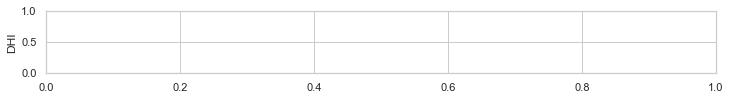

In [32]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

In [ ]:
# ref:
# https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1
# https://machinelearningmastery.com/lstm-autoencoders/
window_length = IN_STEPS
output_length = OUT_STEPS
feats = 6

autoencoder_model = tf.keras.Sequential([
#     keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'), 
    keras.layers.RepeatVector(output_length, name='encoder_decoder_bridge'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'),
    keras.layers.TimeDistributed(keras.layers.Dense(feats))
                          ])


# autoencoder_model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history_encode = compile_and_fit(autoencoder_model, multi_window, epochs=100)
plot_history(history_encode)

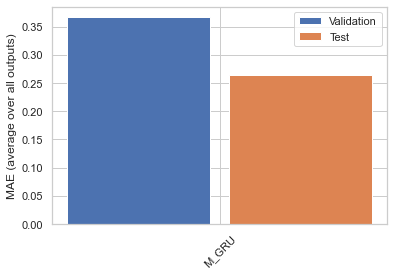

In [33]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_gru_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [84]:
## 날짜, 시간을 행렬로 정의하여 for문 구현을 통한 파일 생성 가능
import numpy as np
import pandas as pd

day = ["Day7","Day8"]
hour = np.arange(0,24,1)
minute = ["00", "30"]

for i in range(len(day)):
    for o in range(len(hour)):
        for p in range(len(minute)):
            outputfilename = 'Filename' + '.csv' +'_'+day[i]+'_' + str(hour[o]) +'h' + minute[p] + 'm'
            print(outputfilename)
            #index, Target
            a=[outputfilename,1,2,3,4,5,6,7,8,9]
            df_a=pd.DataFrame([a],\
                  columns = ['id', 'q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7', 'q_0.8', 'q_0.9' ])
            df_a.to_csv(outputfilename)
            print(df_a) #index가 같이 저장되는데 나중에 drop시키면 됨

'''
f = open(outputfilename,"w",encoding="UTF-8")
f.write("id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9")
a=["0","1"] #결과치를 one hot encoding으로 정의하여 string으로 정의
f.write(outputfilename+","+a[0]+","+a[1])
f.close()
'''

Filename.csv_Day7_0h00m
                        id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_0h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_0h30m
                        id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_0h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_1h00m
                        id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_1h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_1h30m
                        id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_1h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_2h00m
                        id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_

                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_19h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_19h30m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_19h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_20h00m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_20h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_20h30m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_20h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day7_21h00m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day7_21h00m     

                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day8_16h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day8_16h30m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day8_16h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day8_17h00m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day8_17h00m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day8_17h30m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day8_17h30m      1      2      3      4      5      6      7   

   q_0.8  q_0.9  
0      8      9  
Filename.csv_Day8_18h00m
                         id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0  Filename.csv_Day8_18h00m     

'\nf = open(outputfilename,"w",encoding="UTF-8")\nf.write("id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9")\na=["0","1"] #결과치를 one hot encoding으로 정의하여 string으로 정의\nf.write(outputfilename+","+a[0]+","+a[1])\nf.close()\n'